In [1]:
### Import
from pycoingecko import CoinGeckoAPI
from datetime import datetime
from pprint import pprint
import numpy as np
import pandas as pd
import math
import pulp
import matplotlib.pyplot as plt


client = CoinGeckoAPI()

In [13]:
### Configuration
from_date_str = "01-01-2019"
to_date_str = "08-02-2021"

from_date = datetime.strptime(from_date_str, '%d-%m-%Y')
to_date = datetime.strptime(to_date_str, '%d-%m-%Y')

coins_list = [
    'bitcoin', 'ethereum', 'tezos', 'binancecoin', 
    'litecoin', 'chainlink', 'polkadot', 'eos', 'stellar', 
    'aave', 'uniswap', 'maker', 'yearn-finance', 'compound-governance-token', 'algorand', 
    'icon', 'ampleforth', 'kyber-network', 'enjincoin', 'elrond-erd-2', 'solana','balancer', 'cosmos', 
    'ftx-token', '0x', 'algorand'
]

coins_list = [
    'bitcoin', 'ethereum', 'binancecoin', 
    'litecoin', 'chainlink', 'eos', 'stellar', 
    'aave', 'uniswap', 'maker', 'yearn-finance', 'compound-governance-token', 'algorand', 
    'kyber-network', 'ftx-token', '0x',# 'algorand'
]

coins_list = [
    'bitcoin', 'ethereum', 'binancecoin', 
    'chainlink', 'eos', 'yearn-finance','aave',
    'stellar', 'ftx-token', "havven"
]
#haaven = snx
coins_list = [
    'bitcoin', 'ethereum', 'chainlink', 'aave', 'uniswap', 'yearn-finance',"havven", "theta-token", "tezos", "the-graph", "api3", "terra-virtua-kolect", 
    "1inch", "oasis-network", "ramp", 'binancecoin', "crypto-com-chain"
]
coins_list = [
    'chainlink', 'aave', 'yearn-finance',"havven", "theta-token", "the-graph", "api3", "terra-virtua-kolect", 
]
a = client.get_coin_by_id('ethereum')
CONFIG_DICT = {
    "risk_free_rate_of_return" : 1,
    "risk_condition": 2,
    "completness_condition": 100,
}

In [14]:
### Stats Data
to_data = {}

for coin in coins_list:
    print(coin)
    _ = client.get_coin_by_id(coin)
    to_data[coin] = {
        "1d": _['market_data']["price_change_percentage_24h"],
        "7d": _['market_data']["price_change_percentage_7d"],
        "30d": _['market_data']["price_change_percentage_30d"],
        "1y": _['market_data']['price_change_percentage_1y'],
        "alexa_rank": _['public_interest_stats']['alexa_rank'],
        "symbol": _["symbol"]
    }


chainlink
aave
yearn-finance
havven
theta-token
the-graph
api3
terra-virtua-kolect


KeyError: 'bitcoin'

In [16]:
### Historical Data
to_csv = {}
list_csv = []
tickers = {}
for coin in coins_list:
    _ = client.get_coin_market_chart_range_by_id(coin, 'usd', datetime.timestamp(from_date), datetime.timestamp(to_date))

    prices_list = _['prices']
    total_volumes_list = _['total_volumes']
    market_caps_list = _['market_caps']
    
    flat_timestamp = [el[0] for el in prices_list]
    flat_price = [el[1] for el in prices_list]
    flat_total_volume = [el[1] for el in total_volumes_list]
    flat_market_cap = [el[1] for el in market_caps_list]

    tmp = []

    for i in range(len(flat_timestamp)):
        _ = {}
        #_["timestamp"] = datetime.utcfromtimestamp(int(flat_timestamp[i]/1000)).strftime('%Y-%m-%d %H:%M:%S')
        #_["price"] = flat_price[i]
        #_["total_volume"] = flat_total_volume[i]
        #_["market_cap"] = flat_market_cap[i]
        
        #_[datetime.utcfromtimestamp(int(flat_timestamp[i]/1000)).strftime('%Y-%m-%d %H:%M:%S')] = {"price": flat_price[i], "total_volume": flat_total_volume[i], "market_cap": flat_market_cap[i]}
        tmp.append({
            #"date": datetime.utcfromtimestamp(int(flat_timestamp[i]/1000)).strftime('%Y-%m-%d %H:%M:%S'),
            "date": pd.Timestamp(flat_timestamp[i], unit='ms', tz="UTC"),
            "price": flat_price[i], 
            "total_volume": flat_total_volume[i], 
            "market_cap": flat_market_cap[i],
            "coin_name": coin,
        })
    df = pd.DataFrame(tmp, columns=("date", "price", "total_volume","market_cap", "coin_name"))
    # test = pd.MultiIndex.from_tuples(to_csv, names=["first", "second", "third", "fourth", "fifth"])
    #df = pd.DataFrame(list_csv, columns=("timestamp", "price", "total_volume","market_cap", "coin_name")) 
    df.set_index(["date"])
    tickers[coin] = df
    #pprint(tmp)
    #to_csv.append(tmp)
    #list_csv.append(tmp)
    #to_csv.update(tmp)

#pprint(tickers["bitcoin"]["market_cap"].iloc[-1])
mcaps = {
    i: tickers[i]["market_cap"].iloc[-1] for i in coins_list
}
pprint(mcaps)

#pprint(list_csv)
#test = [timestamp, prices_list, total_volumes_list, market_caps_list]
#test = zip(timestamp, prices_list[1], total_volumes_list[1], market_caps_list[1])
#test = zip(timestamp, a, b, c)
#csv_dict = {"timestamp": timestamp, "prices": prices_list, "total_volumes": total_volumes_list, "market_caps": market_caps_list}

{'aave': 5806202408.699114,
 'api3': 93421229.1923153,
 'chainlink': 10169663770.573244,
 'havven': 2998291479.615384,
 'terra-virtua-kolect': 11931023.681482917,
 'the-graph': 1057428970.2051176,
 'theta-token': 2282306677.572686,
 'yearn-finance': 947155760.8605325}


In [17]:
### Calcul des Perfs/Volatilité Weekly/Daily

for coin in coins_list:
    _ = tickers[coin]
    _["daily_perfs"] = _["price"].pct_change()
    _["cum_daily_perfs"] = _["daily_perfs"].cumsum()
    #print(_.loc[(_["date"].dt.day_name() == 'Monday')]['price'].pct_change())
    _["weekly_perfs"] = _.loc[(_["date"].dt.day_name() == 'Monday')]['price'].pct_change()
    _["cum_weekly_perfs"] = _["weekly_perfs"].cumsum()
    #_["weekly_perfs"] = _.lo
    #print(_)
    #print(_["weekly_perfs"])
    #_["weekly_perfs"] = _["price"].pct_change(freq='M')

pd.set_option("display.max_rows", 10, "display.max_columns", 30)
#print(tickers)

#print(tickers["bitcoin"].info())
#tickers["bitcoin"].describe()


In [18]:
### Covariance
import pypfopt
from pypfopt import (
    EfficientFrontier, HRPOpt,  objective_functions, 
    CLA, risk_models, expected_returns, plotting
)
    

from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

#Test avec les différent join pour les ticker soù les dimensions de prix ne matchent pas
# min_periods dans la covar pour enlever si il n'y a pas assez de data
price_matrix = pd.concat([tickers[coin]["price"].rename(coin) for coin in coins_list], axis=1, join='outer')
#price_matrix.cov()
#price_matrix.reset_index(drop=True, inplace=True)
# pour rajouter les date au dataframe de prix
#date_price_matrix = pd.concat([tickers[coin]["date"], price_matrix], axis=1, join='inner')
#df = date_price_matrix
df = price_matrix
tickers = price_matrix
#print(tickers)


Expected annual return: 194.5%
Annual volatility: 3.6%
Sharpe Ratio: 53.15
Discrete allocation: {'chainlink': 13, 'aave': 4, 'havven': 9, 'theta-token': 113, 'the-graph': 2144, 'api3': 407, 'terra-virtua-kolect': 13823}
Funds remaining: $1781.31


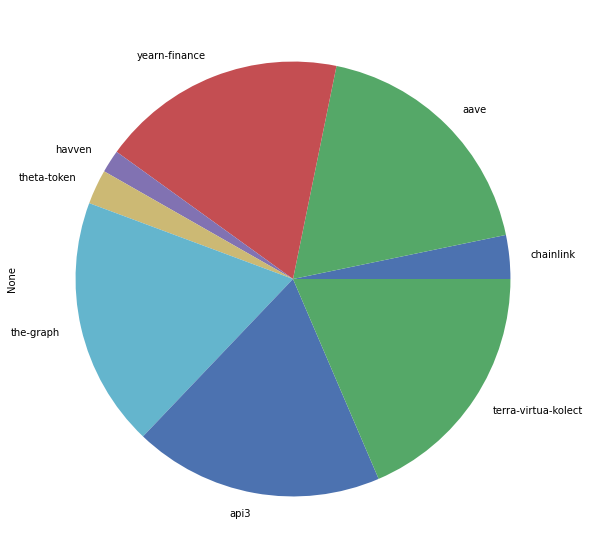

In [20]:
### NORMAL EMA/MEAN HISTORICAL VALUE

#mu = expected_returns.mean_historical_return(df)
#mu = expected_returns.ema_historical_return(df)

mu = expected_returns.capm_return(df)
#mu = expected_returns.returns_from_prices(df)
#mu = expected_returns.prices_from_returns(df)

#S = risk_models.sample_cov(df)
#S = risk_models.semicovariance(df)
#S = risk_models.exp_cov(df)
S = risk_models.min_cov_determinant(df)
#S = risk_models.CovarianceShrinkage(df.cov(min_periods=15))
#S = risk_models.risk_matrix(prices=df, method='ledoit_wolf')
#S = risk_models.risk_matrix(prices=df, method='ledoit_wolf_single_factor')
#S = risk_models.risk_matrix(prices=df, method='oracle_approximating')

#mu.plot.barh(figsize=(10,5))
#plotting.plot_covariance(S, plot_correlation=True)
risk_free_rate = 0.01 # 1% US Bond rate
broker_fees = 0.001 # 0.1% IB
capital = 10000
initial_weights = np.array([1/len(tickers.columns)] * len(tickers.columns))
#initial_weights = np.array([
#    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.11, 9.11, 7.73, 7.85, 5.80, 4.89
#])

gamma = 0.1

ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=broker_fees) # 0.1% broker commission
ef.add_objective(objective_functions.L2_reg, gamma=gamma) 

ef.min_volatility()
#ef.max_sharpe()
#ef.max_quadratic_utility()
#ef.min_efficient_risk(0.5)
#ef.min_efficient_return(0.5)


cleaned_weights = ef.clean_weights()
#print(cleaned_weights)
ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate) 

pd.Series([abs(i) for i in cleaned_weights.values()]).plot.pie(figsize=(10,10), normalize=True, labels=cleaned_weights.keys())

latest_prices = get_latest_prices(df)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=capital)#, short_ratio=0.5)

allocation, leftover = da.lp_portfolio()
#allocation, leftover = da.greedy_portfolio()

print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

#pd.Series(cleaned_weights).plot.pie(figsize=(10,10))

In [21]:
### NORMAL EMA/MEAN HISTORICAL VALUE
risk_free_rate = 0.01
broker_fees = 0.001
capital = 10000
initial_weights = np.array([1/len(tickers.columns)] * len(tickers.columns))
#initial_weights = np.array([
#    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.11, 9.11, 7.73, 7.85, 5.80, 4.89
#])
return_list = {
    'mean': expected_returns.mean_historical_return(df),
    'ema': expected_returns.ema_historical_return(df),
    'capm': expected_returns.capm_return(df),
}

risk_list = {
    'sample_cov': risk_models.sample_cov(df),
    'semi_cov': risk_models.semicovariance(df),
    'exp_cov': risk_models.exp_cov(df),
    'min_cov_det': risk_models.min_cov_determinant(df),
    #'cov_shrink': risk_models.CovarianceShrinkage(df.cov(min_periods=100)),
    'ledoit_wolf': risk_models.risk_matrix(prices=df, method='ledoit_wolf'),
    'ld_wolf_single': risk_models.risk_matrix(prices=df, method='ledoit_wolf_single_factor'),
    'oracle_approx': risk_models.risk_matrix(prices=df, method='oracle_approximating'),
}

result = {}

for return_name, ret in return_list.items():
    for risk_name, risk in risk_list.items():
        print((return_name, risk_name))
        for i in np.arange(0, 1, 0.01):
        #for i in np.arange(0, 1, 0.1):
            gamma = i

            ef = EfficientFrontier(ret, risk, weight_bounds=(0, 1))
            ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=broker_fees) 
            ef.add_objective(objective_functions.L2_reg, gamma=gamma)  

            ef.min_volatility()
            #ef.max_sharpe()
            #ef.max_quadratic_utility()
            #ef.min_efficient_risk(0.5)
            #ef.min_efficient_return(0.5)

            cleaned_weights = ef.clean_weights()
            portfolio_performance = ef.portfolio_performance(verbose=False, risk_free_rate=risk_free_rate) 


            latest_prices = get_latest_prices(df)
            da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=capital)
            allocation, leftover = da.lp_portfolio()
            result[(return_name, risk_name, i)] = {
                "return": portfolio_performance[0],
                "risk": portfolio_performance[1],
                "sharpe ratio": portfolio_performance[2],
                "allocation": allocation,
                "leftover": leftover,
                "cleaned_weights": cleaned_weights,
                "return_name": return_name,
                "risk_name": risk_name,
            }
            #allocation, leftover = da.greedy_portfolio()

            #print("Discrete allocation:", allocation)
            #print("Funds remaining: ${:.2f}".format(leftover))
#pprint(result)
print("FINISHED !")

('mean', 'sample_cov')
('mean', 'semi_cov')
('mean', 'exp_cov')
('mean', 'min_cov_det')
('mean', 'ledoit_wolf')
('mean', 'ld_wolf_single')
('mean', 'oracle_approx')
('ema', 'sample_cov')
('ema', 'semi_cov')
('ema', 'exp_cov')
('ema', 'min_cov_det')
('ema', 'ledoit_wolf')
('ema', 'ld_wolf_single')
('ema', 'oracle_approx')
('capm', 'sample_cov')
('capm', 'semi_cov')
('capm', 'exp_cov')
('capm', 'min_cov_det')
('capm', 'ledoit_wolf')
('capm', 'ld_wolf_single')
('capm', 'oracle_approx')
FINISHED !


======== B ========
4.145225846474534
======================== Expected performance =================
annual return: 414.523%
annual volatility: 34.713%
sharpe ratio: 11.9
Discrete allocation: {'chainlink': 36, 'aave': 4, 'havven': 37, 'theta-token': 445, 'the-graph': 1351, 'api3': 373, 'terra-virtua-kolect': 12315}
Funds remaining: $906.05
Return type: ema
Risk type: ledoit_wolf


<AxesSubplot:ylabel='None'>

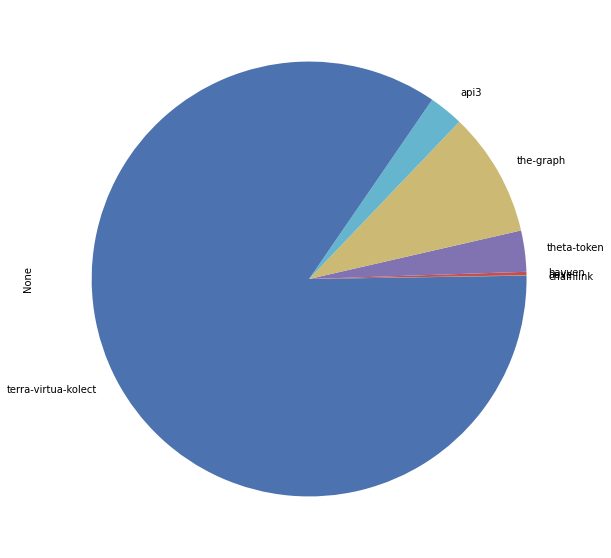

In [22]:
#pprint(result)
  
b = {k: v['return'] for k, v in sorted(result.items(), key=lambda item: item[1]["return"])}
print("======== B ========")
#print(b.items())
max_values = max(list(b.values()))
print(max_values)

opt_portfolio = [(k, v) for k, v in b.items() if v == max_values] # getting all keys containing the `maximum`
last = result[opt_portfolio[0][0]]
#print(last)

print("======================== Expected performance =================")
print(f"annual return: {last['return']:.3%}")
print(f"annual volatility: {last['risk']:.3%}")
print(f"sharpe ratio: {last['sharpe ratio']:.3}")
print(f"Discrete allocation: {last['allocation']}")
print(f"Funds remaining: ${last['leftover']:.2f}")
print(f"Return type: {last['return_name']}")
print(f"Risk type: {last['risk_name']}")

pd.Series([abs(i) for i in last['allocation'].values()]).plot.pie(figsize=(10,10), normalize=True, labels=last['allocation'].keys())

weight: OrderedDict([('chainlink', 0.04506), ('aave', 0.23054), ('yearn-finance', 0.06869), ('havven', 0.02974), ('theta-token', 0.06792), ('the-graph', 0.06764), ('api3', 0.24661), ('terra-virtua-kolect', 0.24381)])
Discrete allocation: {'api3': 540, 'terra-virtua-kolect': 18160, 'aave': 5, 'theta-token': 297, 'the-graph': 781, 'chainlink': 17, 'havven': 14}
Funds remaining: $678.14


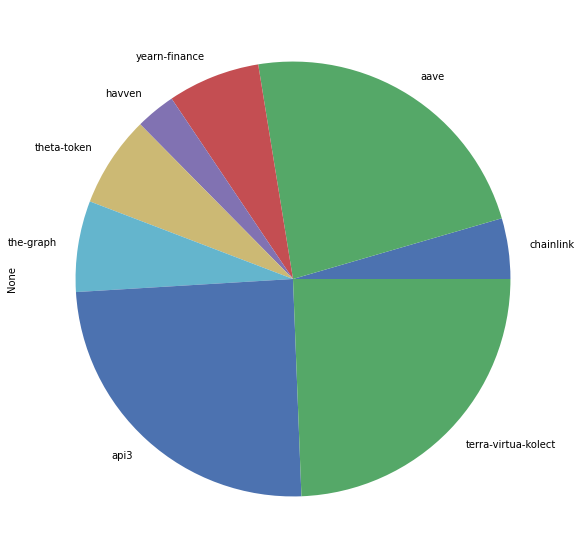

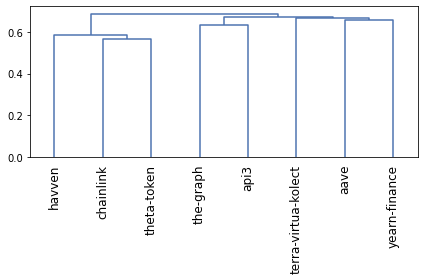

In [24]:
### HRPOPT TECHNIQUE
capital = 10000
risk_free_rate = 0.01

#mu.plot.barh(figsize=(10,5))
#plotting.plot_covariance(S, plot_correlation=True)

from pypfopt import expected_returns
rets = expected_returns.returns_from_prices(df)
#rets.tail()


#ef = HRPOpt(mu, S)

hrp = HRPOpt(rets)
hrp.optimize()
#weights = hrp.clean_weights()
#weights

#import scipy.cluster.hierarchy as sch
#print(sch._LINKAGE_METHODS)
weights = hrp.clean_weights()

#print(f"raw_weights: {raw_weights}")
print(f"weight: {weights}")

#ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

latest_prices = get_latest_prices(df)
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=capital)

#da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=35802, short_ratio=0.3)

#allocation, leftover = da.lp_portfolio()
allocation, leftover = da.greedy_portfolio()

print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

pd.Series([abs(i) for i in weights.values()]).plot.pie(figsize=(10,10), normalize=True, labels=weights.keys())

from pypfopt import plotting

plotting.plot_dendrogram(hrp);

In [20]:
### HRPOPT TECHNIQUE

# En HRP on ne fait pas d'estimation des perfs 
mu = df

S = risk_models.risk_matrix(prices=df, method='oracle_approximating')

capital = 20000
risk_free_rate = 0.01

#mu.plot.barh(figsize=(10,5))
#plotting.plot_covariance(S, plot_correlation=True)

ef = HRPOpt(mu, S)

#import scipy.cluster.hierarchy as sch
#print(sch._LINKAGE_METHODS)
result = {}
method_list = ("single", "complete", "average", "weighted", "centroid", "median", "ward")
test = ("single", "complete", "average", "weighted", "median", "ward")
for method in method_list:
    raw_weights = ef.optimize(method)
    #raw_weights = ef.optimize('complete')

    #print(f"ef: {ef}")
    #print(f"raw_weights: {raw_weights}")
    cleaned_weights = ef.clean_weights()
    #print(f"cleaned weight: {cleaned_weights}")

    portfolio_performance = ef.portfolio_performance(verbose=False, risk_free_rate=risk_free_rate)

    latest_prices = get_latest_prices(df)
    da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=capital)

    allocation, leftover = da.lp_portfolio()
    #allocation, leftover = da.greedy_portfolio()

    #print("Discrete allocation:", allocation)
    #print("Funds remaining: ${:.2f}".format(leftover))
    result[method] = {
        "return": portfolio_performance[0],
        "risk": portfolio_performance[1],
        "sharpe ratio": portfolio_performance[2],
        "allocation": allocation,
        "leftover": leftover,
        "method": method,
    }
#pprint(result)
print("FINISHED !")

FINISHED !


======================== Expected performance =================
annual return: 1398.199%
annual volatility: 15.587%
sharpe ratio: 89.6
Discrete allocation: {'theta-token': 3, 'tezos': 1, 'the-graph': 52, 'terra-virtua-kolect': 17275, 'oasis-network': 234152, 'ramp': 708, 'crypto-com-chain': 12464}
Funds remaining: $0.06
Method used: $complete


<AxesSubplot:ylabel='None'>

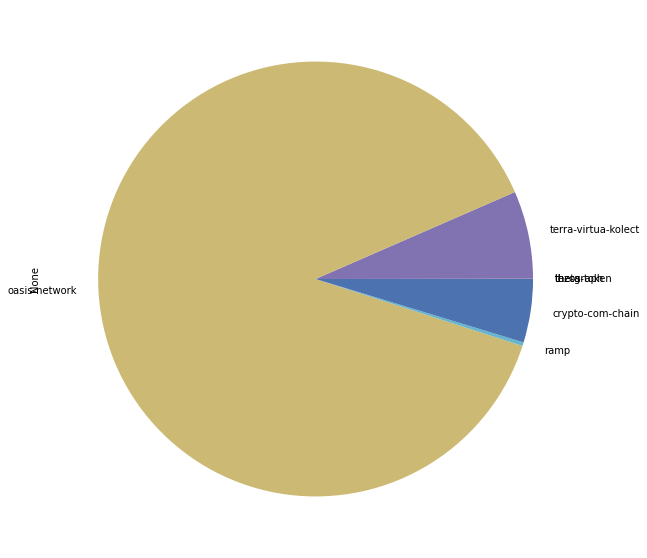

In [21]:
#pprint(result)
  
b = {k: v['return'] for k, v in sorted(result.items(), key=lambda item: item[1]["return"])}
#print("======== B ========")
#print(b.items())

max_values = max(list(b.values()))
#print(max_values)

opt_portfolio = [(k, v) for k, v in b.items() if v == max_values] # getting all keys containing the `maximum`
last = result[opt_portfolio[0][0]]
#print(last)

print("======================== Expected performance =================")
print(f"annual return: {last['return']:.3%}")
print(f"annual volatility: {last['risk']:.3%}")
print(f"sharpe ratio: {last['sharpe ratio']:.3}")
print(f"Discrete allocation: {last['allocation']}")
print(f"Funds remaining: ${last['leftover']:.2f}")
print(f"Method used: ${last['method']}")

pd.Series([abs(i) for i in last['allocation'].values()]).plot.pie(figsize=(10,10), normalize=True, labels=last['allocation'].keys())


OrderedDict([('bitcoin', 0.40649), ('ethereum', 0.0482), ('binancecoin', 0.08787), ('chainlink', 0.12949), ('eos', -0.13367), ('yearn-finance', 0.03534), ('aave', 0.10471), ('stellar', 0.14814), ('ftx-token', 0.18718), ('havven', -0.01375)])
Expected annual return: 579.5%
Annual volatility: 38.7%
Sharpe Ratio: 14.91
Discrete allocation: {'bitcoin': 3, 'ethereum': 7, 'binancecoin': 116, 'chainlink': 7527, 'aave': 21, 'stellar': 36702, 'ftx-token': 4412, 'eos': -1759, 'havven': -15125}
Funds remaining: $0.06


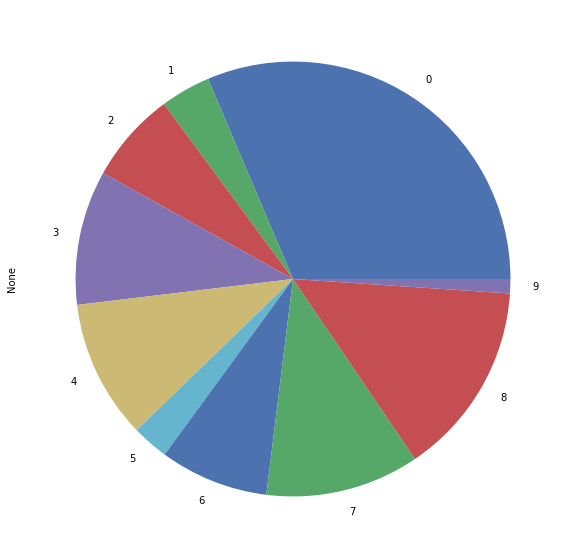

In [22]:
### CLA TECHNIQUE

#mu = expected_returns.mean_historical_return(df)
#mu = expected_returns.ema_historical_return(df)
mu = expected_returns.capm_return(df)
#mu = expected_returns.returns_from_prices(df)
#mu = expected_returns.prices_from_returns(df)

#S = risk_models.sample_cov(df)
#S = risk_models.semicovariance(df)
#S = risk_models.exp_cov(df)
#S = risk_models.min_cov_determinant(df)
#S = risk_models.CovarianceShrinkage(df.cov(min_periods=15))
#S = risk_models.risk_matrix(prices=df, method='ledoit_wolf')
#S = risk_models.risk_matrix(prices=df, method='ledoit_wolf_single_factor')
S = risk_models.risk_matrix(prices=df, method='oracle_approximating')

#mu.plot.barh(figsize=(10,5))
#plotting.plot_covariance(S, plot_correlation=True)



# Pretend that you started with a default-weight allocation
initial_weights = np.array([1/len(tickers.columns)] * len(tickers.columns))

ef = CLA(mu, S, weight_bounds=(-1, 1))
#ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.001) # 1% broker commission
#ef.add_objective(objective_functions.L2_reg, gamma=0.05)  # default is gamma=1

ef.min_volatility()
#ef.max_sharpe()


#ef.efficient_frontier()



cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True, risk_free_rate=0.02)

pd.Series([abs(i) for i in cleaned_weights.values()]).plot.pie(figsize=(10,10))

latest_prices = get_latest_prices(df)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=20000, short_ratio=0.3)

allocation, leftover = da.lp_portfolio()
#allocation, leftover = da.greedy_portfolio()

print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

#pd.Series(cleaned_weights).plot.pie(figsize=(10,10))

bitcoin        0.197887
ethereum       0.222379
binancecoin    0.111000
chainlink      0.065410
eos            0.200622
dtype: float64
                Prior  Posterior  Views
bitcoin      0.685188   0.197887   0.10
ethereum     0.476660   0.222379   0.30
binancecoin  0.473680   0.111000   0.05
chainlink    0.529915   0.065410   0.05
eos          0.193434   0.200622   0.20


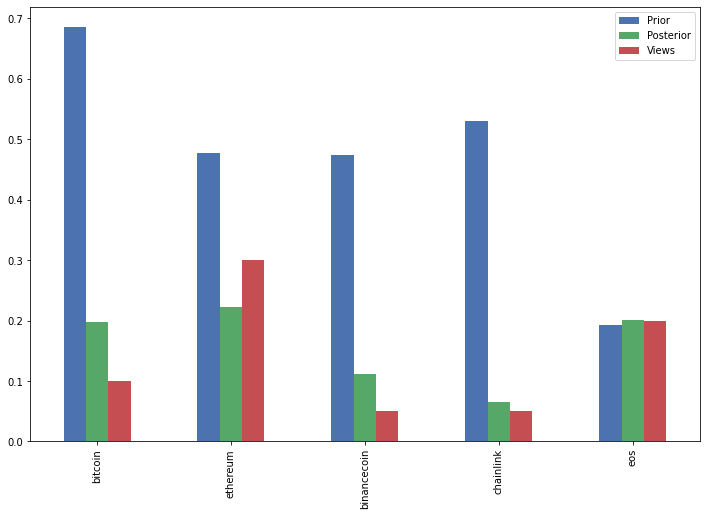

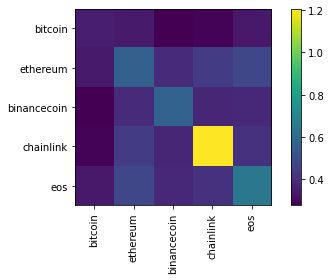

ValueError: Data must be 1-dimensional

In [8]:
# Black-Litterman

from pypfopt import black_litterman, risk_models

"""
cov_matrix is a NxN sample covariance matrix
mcaps is a dict of market caps
market_prices is a series of S&P500 prices
"""

from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(df).ledoit_wolf()
#print(S)
delta = black_litterman.market_implied_risk_aversion(df) # Je trouve le Delta elevé
#print(delta)
#plotting.plot_covariance(S, plot_correlation=True);

#print(tickers["bitcoin"]["market_cap"].iloc[-1])
mcaps = {i:tickers[i]["market_cap"].iloc[-1] for i in coins_list}
#print(mcaps)
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
#print(market_prior)

#market_prior.plot.barh(figsize=(10,5));

# Contruction de la view pour estimer

# Relative View
"""Each view has a corresponding row in the picking matrix (the order matters)
Absolute views have a single 1 in the column corresponding to the ticker’s order in the universe.
Relative views have a positive number in the nominally outperforming asset columns and a negative number in the nominally underperforming asset columns. 
The numbers in each row should sum up to 0."""

Q = np.array([-0.20, 0.05, 0.10, 0.15]).reshape(-1, 1) # Absolute
P = np.array( # Relative
    [
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0.5, 0.5, -0.5, -0.5, 0, 0],
    ]
)
# Absolute View
viewdict = {
    "bitcoin": 0.10,
    "ethereum": 0.30,
    "binancecoin": 0.05,
    "chainlink": 0.05,
    "eos": 0.20,
}

# Optionnal - Arbitrary confidences
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7
]
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, view_confidences=confidences, omega="idzorek", tau=0.05)
# Optionnal - Standar deviation confidences

intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
]
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

#print(variances)
omega = np.diag(variances)

# We are using the shortcut to automatically compute market-implied prior
# pi = market_prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, absolute_views=viewdict, omega=omega, tau=0.05)
# argument de BlackLuttermanModel (cov_matrix, pi=None, absolute_views=None, Q=None, P=None, omega=None, view_confidences=None, tau=0.05, risk_aversion=1)

#fig, ax = plt.subplots(figsize=(7,7))
#im = ax.imshow(bl.omega)

# We want to show all ticks...
#ax.set_xticks(np.arange(len(bl.tickers)))
#ax.set_yticks(np.arange(len(bl.tickers)))

#ax.set_xticklabels(bl.tickers)
#ax.set_yticklabels(bl.tickers)
#plt.show()
#np.diag(bl.omega)

# Posterior estimate of returns
ret_bl = bl.bl_returns()
print(ret_bl)
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
print(rets_df)

rets_df.plot.bar(figsize=(12,8));
# Posterior covariance estimate
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

from pypfopt import EfficientFrontier, objective_functions

## 2 Facon d'avoir les poids

# USE return-implied weights
bl.bl_weights(delta)
weights = bl.clean_weights()


# Ou autrement
#ef = EfficientFrontier(ret_bl, S_bl)
#ef.add_objective(objective_functions.L2_reg)
#ef.max_sharpe()
#bl.bl_weights(delta)
#weights = ef.clean_weights()


pd.Series(weights).plot.pie(figsize=(10,10));


from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, df.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

=== PRICES (df) ====
                                bitcoin     ethereum  binancecoin  chainlink  \
date                                                                           
2020-10-03 00:00:00+00:00  10572.674843   345.912568    27.247630   9.216383   
2020-10-04 00:00:00+00:00  10546.656255   345.992463    28.220218   9.266724   
2020-10-05 00:00:00+00:00  10670.700811   352.458807    28.973668   9.410709   
2020-10-06 00:00:00+00:00  10784.949403   353.604427    28.602978   9.611591   
2020-10-07 00:00:00+00:00  10605.957791   340.616022    27.673154   8.774650   
...                                 ...          ...          ...        ...   
2021-01-06 00:00:00+00:00  34082.206049  1103.358252    41.700028  14.575731   
2021-01-07 00:00:00+00:00  36933.520137  1208.575093    42.182863  17.133775   
2021-01-08 00:00:00+00:00  39547.084081  1229.471315    43.399504  16.056294   
2021-01-09 00:00:00+00:00  40815.961855  1223.729688    42.466680  15.289228   
2021-01-10 00:00:00

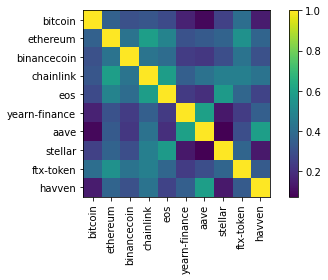

=== MARKET PRIOR ====
bitcoin          4.626878
ethereum         3.262384
binancecoin      1.864956
chainlink        3.071850
eos              2.490222
yearn-finance    2.432914
aave             1.718350
stellar          4.364094
ftx-token        2.534249
havven           1.945827
dtype: float64
==== VIEWDICT =====
{'bitcoin': 0.1, 'ethereum': 0.1, 'binancecoin': 0.1, 'chainlink': 0.1, 'aave': 0.1}
==== INTERVALS =====
[(0, 0.1), (0, 0.1), (0, 0.1), (0, 0.1), (0, 0.1)]
==== VARIANCES =====
[0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005]
==== OMEGA =====
[[0.0025 0.     0.     0.     0.    ]
 [0.     0.0025 0.     0.     0.    ]
 [0.     0.     0.0025 0.     0.    ]
 [0.     0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.     0.0025]]
==== RET_BLACKLITTERMAN =====
bitcoin          0.551057
ethereum         0.202439
binancecoin      0.111199
chainlink        0.120930
eos              0.194406
yearn-finance    0.19

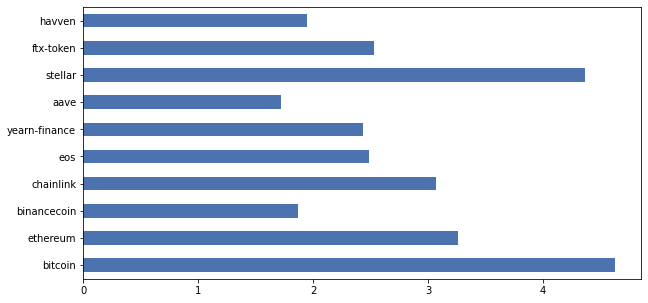

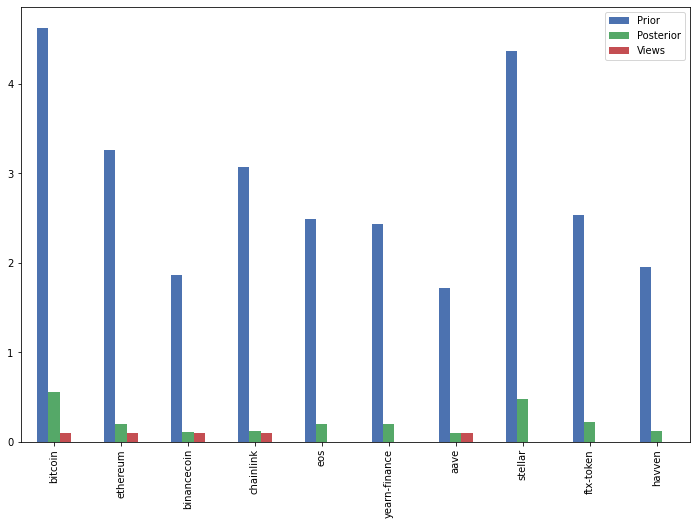

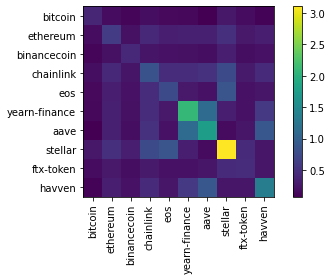

======== B ========
[0.0]
Expected annual return: 30.2%
Annual volatility: 48.6%
Sharpe Ratio: 0.62
======================== Expected performance =================
annual return: 30.154%
annual volatility: 48.619%
sharpe ratio: 0.618
{'ethereum': 1, 'binancecoin': 140, 'eos': 388, 'aave': 7, 'ftx-token': 349, 'havven': 31}
Leftover: $6565.70


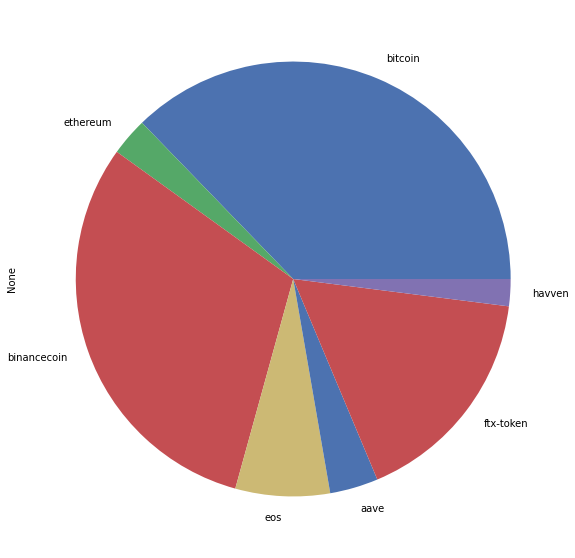

In [16]:
# Black-Litterman

from pypfopt import black_litterman, risk_models

"""
cov_matrix is a NxN sample covariance matrix
mcaps is a dict of market caps
market_prices is a series of S&P500 prices
"""

from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

print("=== PRICES (df) ====")
"""
for k in price_matrix:
    v.set_index("date", inplace=True)

for k,v in df.items():
    v.set_index("date", inplace=True)
"""
df = price_matrix
print(df)
print(df.info())
print(df["bitcoin"])
print(type(df["bitcoin"]))

print("=== MCAPS ====")
print(mcaps)

S = risk_models.CovarianceShrinkage(df).ledoit_wolf()
print("=== RISK MODEL ====")
print(S)
market_prices = tickers["bitcoin"]
delta = black_litterman.market_implied_risk_aversion(market_prices)
print("=== DELTA ====")
print(delta)
#delta = 2.5042720332949346

plotting.plot_covariance(S, plot_correlation=True);

"""
ANCIEN CALCUL FAIT CELLULE 1
print(tickers["bitcoin"]["market_cap"].iloc[-1])
#mcaps = {i:tickers[i].iloc[-1] for i in coins_list}

print("==== MCAPS =====")
print(mcaps)
### MCAPS == PRICE != MARKET_CAP
"""

market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
print("=== MARKET PRIOR ====")
print(market_prior)

market_prior.plot.barh(figsize=(10,5));
risk_free_rate = 0.001
broker_fees = 0.001
initial_weights = np.array([1/len(tickers.columns)] * len(tickers.columns))
#initial_weights = np.array([
#    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.11, 9.11, 7.73, 7.85, 5.80, 4.89
#])
# Contruction de la view pour estimer

# Relative View
"""Each view has a corresponding row in the picking matrix (the order matters)
Absolute views have a single 1 in the column corresponding to the ticker’s order in the universe.
Relative views have a positive number in the nominally outperforming asset columns and a negative number in the nominally underperforming asset columns. 
The numbers in each row should sum up to 0."""

"""
Q = np.array([-0.20, 0.05, 0.10, 0.15]).reshape(-1, 1) # Absolute
P = np.array( # Relative
    [
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0.5, 0.5, -0.5, -0.5, 0, 0],
    ]
)
# Absolute View
viewdict = {
    "bitcoin": 0.10,
    "ethereum": 0.30,
    "binancecoin": 0.05,
    "chainlink": 0.05,
    "eos": 0.20,
}

# Optionnal - Arbitrary confidences
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7
]
"""
#bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, view_confidences=confidences, omega="idzorek", tau=0.05)
# Optional - Standard deviation confidences
# Absolute View
"""
viewdict = {
    "ABNB": 0.10, 
    "V": 0.10, 
    "AMD": 0.10, 
    "CSCO": 0.10,
    "HNI": 0.10, 
    "ORI": 0.10, 
    "SPR": 0.10, 
    "XOM": 0.10, 
    "CB": 0.10, 
    "LOW": 0.10, 
    "MDLZ": 0.10, 
    "GRWG": 0.10, 
    "BIIB": 0.10, 
    "NVDA": 0.10, 
    "ADBE": 0.10, 
    "CRSR": 0.10, 
    "INTC": 0.10, 
    "JNJ": 0.10, 
    "JPM": 0.10, 
    "LAZ": 0.10, 
}
"""
coins_list = [
    'bitcoin', 'ethereum', 'binancecoin', 
    'chainlink', 'eos', 'yearn-finance','aave',
    'stellar', 'ftx-token', "havven"
]
viewdict = {}
intervals = []
double_list = (
    [{"bitcoin": 0.10}, (0, 0.1)],
    [{"ethereum": 0.10}, (0, 0.1)],
    [{"binancecoin": 0.10}, (0, 0.1)],
    [{"chainlink": 0.10}, (0, 0.1)],
    [{"aave": 0.10}, (0, 0.1)],
)
for el in double_list:
    viewdict.update(el[0])
    intervals.append(el[1])
"""    
viewdict = {
    "ABNB": 0.10, 
    "V": 0.10, 
    "AMD": 0.10, 
    "CSCO": 0.10,
    "HNI": 0.10, 
}
"""
"""
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
]
"""
"""
intervals = [
    (0, 0.1),
    (0, 0.1),
    (0, 0.1),
    (0, 0.1),
    (0, 0.1),
]
"""

print("==== VIEWDICT =====")
print(viewdict)
print("==== INTERVALS =====")
print(intervals)


variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)
    
print("==== VARIANCES =====")
print(variances)
omega = np.diag(variances)

print("==== OMEGA =====")
print(omega)

# We are using the shortcut to automatically compute market-implied prior
# pi = market_prior
bl = BlackLittermanModel(
    cov_matrix=S, 
    pi="market", 
    absolute_views=viewdict,
    market_caps=mcaps, 
    risk_aversion=delta, 
    omega=omega, 
    tau=0.05, 
    risk_free_rate=risk_free_rate
)
# args de BlackLittermanModel (cov_matrix, pi=None, absolute_views=None, Q=None, P=None, omega=None, view_confidences=None, tau=0.05, risk_aversion=1)
"""
#fig, ax = plt.subplots(figsize=(7,7))
#im = ax.imshow(bl.omega)

# We want to show all ticks...
#ax.set_xticks(np.arange(len(bl.tickers)))
#ax.set_yticks(np.arange(len(bl.tickers)))

#ax.set_xticklabels(bl.tickers)
#ax.set_yticklabels(bl.tickers)
#plt.show()
#np.diag(bl.omega)
"""

# Posterior estimate of returns
ret_bl = bl.bl_returns()
print("==== RET_BLACKLITTERMAN =====")
print(ret_bl)
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T


rets_df.plot.bar(figsize=(12,8));

# Posterior covariance estimate
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);


### PORTFOLIO ALLOCATION
test = {}

from pypfopt import EfficientFrontier, objective_functions
for i in np.arange(0, 1, 0.01):
    gamma = i

    ef = EfficientFrontier(ret_bl, S_bl)
    ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=broker_fees) # 0.1% broker commission
    ef.add_objective(objective_functions.L2_reg, gamma=gamma)  # default is gamma=1

    #ef.max_sharpe() # Pk conflict avec les fonctions de régularisations ?
    ef.min_volatility()
    #bl.bl_weights(delta)
    weights = ef.clean_weights()


    from pypfopt import DiscreteAllocation

    capital = 19500
    portfolio_performance = ef.portfolio_performance(verbose=False, risk_free_rate=risk_free_rate)
    expected_annual_return = portfolio_performance[0]
    expected_annual_volatility = portfolio_performance[1]
    expected_sharpe_ratio = portfolio_performance[2]
    """print("======================== Expected performance =================")
    print(f"annual return: {expected_annual_return:.3%}")
    print(f"annual volatility: {expected_annual_volatility:.3%}")
    print(f"sharpe ratio: {expected_sharpe_ratio:.3}")"""

    da = DiscreteAllocation(weights, df.iloc[-1], total_portfolio_value=capital)
    alloc, leftover = da.lp_portfolio()

    #print(alloc)
    #print(f"Leftover: ${leftover:.2f}")
    test[gamma] = portfolio_performance[2]
#print(test)   
b = {k: v for k, v in sorted(test.items(), key=lambda item: item[1])}
print("======== B ========")
#print(b)
max_value = max(test.values())
max_keys = [k for k, v in test.items() if v == max_value] # getting all keys containing the `maximum`
print(max_keys)

gamma = max_keys[0]


ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=broker_fees) # 0.1% broker commission
ef.add_objective(objective_functions.L2_reg, gamma=gamma)  # default is gamma=1

#ef.max_sharpe() # Pk conflict avec les fonctions de régularisations ?
ef.min_volatility()
#bl.bl_weights(delta)
weights = ef.clean_weights()

pd.Series(weights).plot.pie(figsize=(10,10), normalize=True);

from pypfopt import DiscreteAllocation

capital = 20000
portfolio_performance = ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)
expected_annual_return = portfolio_performance[0]
expected_annual_volatility = portfolio_performance[1]
expected_sharpe_ratio = portfolio_performance[2]
print("======================== Expected performance =================")
print(f"annual return: {expected_annual_return:.3%}")
print(f"annual volatility: {expected_annual_volatility:.3%}")
print(f"sharpe ratio: {expected_sharpe_ratio:.3}")

da = DiscreteAllocation(weights, df.iloc[-1], total_portfolio_value=capital)
alloc, leftover = da.lp_portfolio()

print(alloc)
print(f"Leftover: ${leftover:.2f}")